In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pystan
import math
import io

import warnings
warnings.filterwarnings("ignore")

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = '1iG9B_DNnHscE5yCWIfAZva6Soi4i8khC'

In [48]:
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('train.tsv')  
df = pd.read_csv('train.tsv', sep='\t')
df = df[pd.notnull(df['category_name'])]

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

In [49]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## Data Consolidation

In [0]:
df['log_price'] = np.log(df['price'] + 0.1).values

In [0]:
category_codes = []

for i in df.index:
    category = df['category_name'][i]

    if 'Men' in category:
        category_codes.append(0)
    elif 'Women' in category:
        category_codes.append(1)
    elif 'Electronics' in category:
        category_codes.append(2)
    elif 'Sports' in category:
        category_codes.append(3)
    elif 'Beauty' in category:
        category_codes.append(4)
    elif 'Kids' in category:
        category_codes.append(5)
    elif 'Home' in category:
        category_codes.append(6)
    else:
        category_codes.append(7)

In [0]:
df['category_code'] = category_codes

In [0]:
category_code_new = df.category_code.values
shipping = df.shipping.values
condition_id = df.item_condition_id.values
log_price = df.log_price.values

In [54]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd

env: THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore


In [0]:
n_categories = len(df.category_code.unique())

In [0]:
log_price_t = pm.Minibatch(log_price, 500)
shipping_t = pm.Minibatch(shipping, 500)
condition_t = pm.Minibatch(condition_id, 500)
category_code_t = pm.Minibatch(category_code_new, 500)

In [0]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sigma=10**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=10)

    mu_b = pm.Normal('mu_beta', mu=0., sigma=10**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=10)

    mu_c = pm.Normal('mu_c', mu=0., sigma=10**2)
    sigma_c = pm.Uniform('sigma_c', lower=0, upper=10)

In [0]:
with hierarchical_model:

    a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_categories)
    b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=n_categories)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=n_categories)

In [0]:
with hierarchical_model:
    log_price_est = c[category_code_t] + b[category_code_t] * condition_t + a[category_code_t] * shipping_t

In [0]:
with hierarchical_model:
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)

    # Data likelihood
    lp_like = pm.Normal('lp_like', mu=log_price_est, sigma=eps, observed=log_price_t, total_size=len(df))

In [72]:
with hierarchical_model:
    inference = pm.ADVI()
    approx = pm.fit(100000, method=inference, callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = 566.64: 100%|██████████| 100000/100000 [01:24<00:00, 1181.01it/s]
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 566.57


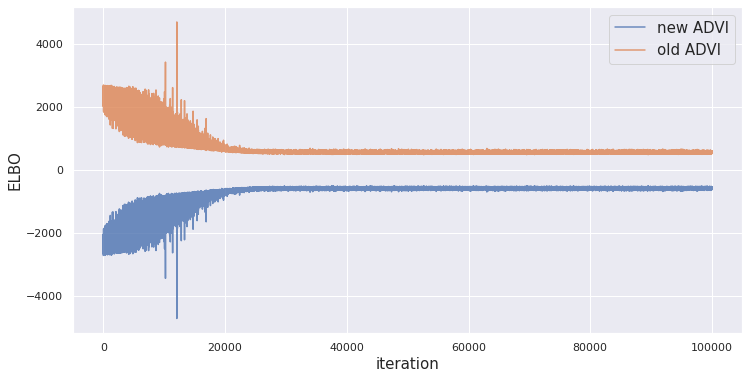

In [73]:
plt.figure(figsize=(12,6))
plt.plot(-inference.hist, label='new ADVI', alpha=.8)
plt.plot(approx.hist, label='old ADVI', alpha=.8)
plt.legend(fontsize=15)
plt.ylabel('ELBO', fontsize=15)
plt.xlabel('iteration', fontsize=15);

In [79]:
min(approx.hist), max(approx.hist)

(490.2292175292969, 4706.71484375)

In [77]:
with hierarchical_model:
    step = pm.NUTS(scaling=approx.cov.eval(), is_cov=True)
    hierarchical_trace = pm.sample(100000, step=step, start=approx.sample()[0], progressbar=True, tune=1000, cores=4)

INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [eps, c, beta, alpha, sigma_c, mu_c, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 4 chains: 100%|██████████| 404000/404000 [07:21<00:00, 915.55draws/s]
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [0]:
means = approx.bij.rmap(approx.mean.eval())
sds = approx.bij.rmap(approx.std.eval())

In [65]:
means

{'alpha': array([-0.23506162, -0.2797209 , -0.5422335 , -0.49201646, -0.3813052 ,
        -0.38751486, -0.510204  , -0.5373531 ], dtype=float32),
 'beta': array([-0.12108995, -0.13293   ,  0.14173238, -0.05671879, -0.02921723,
        -0.03844833, -0.12917933,  0.05798578], dtype=float32),
 'c': array([3.5205402, 3.3979976, 2.9624405, 3.1683626, 2.9817307, 2.9760368,
        3.289888 , 2.8874059], dtype=float32),
 'eps_interval__': array(-4.881575, dtype=float32),
 'mu_alpha': array(-0.00022505, dtype=float32),
 'mu_beta': array(6.097043e-05, dtype=float32),
 'mu_c': array(0.00212902, dtype=float32),
 'sigma_alpha_interval__': array(-0.46019742, dtype=float32),
 'sigma_beta_interval__': array(-0.46046427, dtype=float32),
 'sigma_c_interval__': array(-0.4548831, dtype=float32)}

In [66]:
sds

{'alpha': array([0.01464905, 0.00532522, 0.00948473, 0.02293007, 0.00713198,
        0.00905106, 0.01723541, 0.00980759], dtype=float32),
 'beta': array([0.00365494, 0.00147027, 0.00365225, 0.00730314, 0.00343223,
        0.00252215, 0.00514578, 0.00414704], dtype=float32),
 'c': array([0.00840837, 0.00319645, 0.00767941, 0.01503661, 0.00547363,
        0.00589629, 0.00922903, 0.00732972], dtype=float32),
 'eps_interval__': array(0.00263449, dtype=float32),
 'mu_alpha': array(0.7320357, dtype=float32),
 'mu_beta': array(0.7320404, dtype=float32),
 'mu_c': array(0.7320338, dtype=float32),
 'sigma_alpha_interval__': array(0.75980437, dtype=float32),
 'sigma_beta_interval__': array(0.760518, dtype=float32),
 'sigma_c_interval__': array(0.7577999, dtype=float32)}

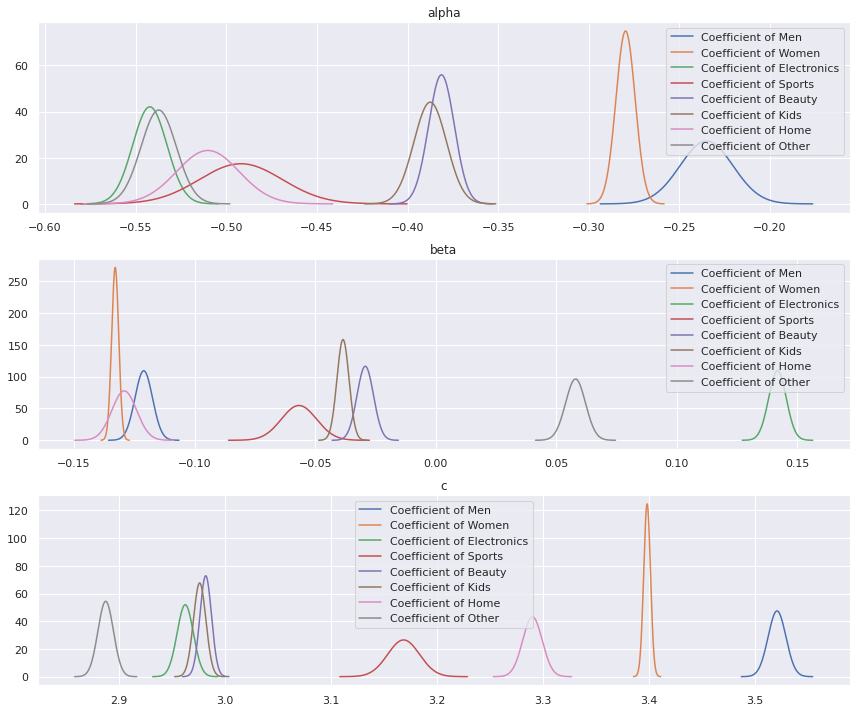

In [101]:
from scipy import stats

category_names = ['Men','Women','Electronics','Sports','Beauty','Kids','Home','Other']
model_param = ['alpha','beta','c']
varnames = means.keys()
fig, axs = plt.subplots(nrows=3, figsize=(12, 10))

for var, ax in zip(model_param, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y, label='Coefficient of {}'.format(category_names[i]))
    ax.legend()
fig.tight_layout()

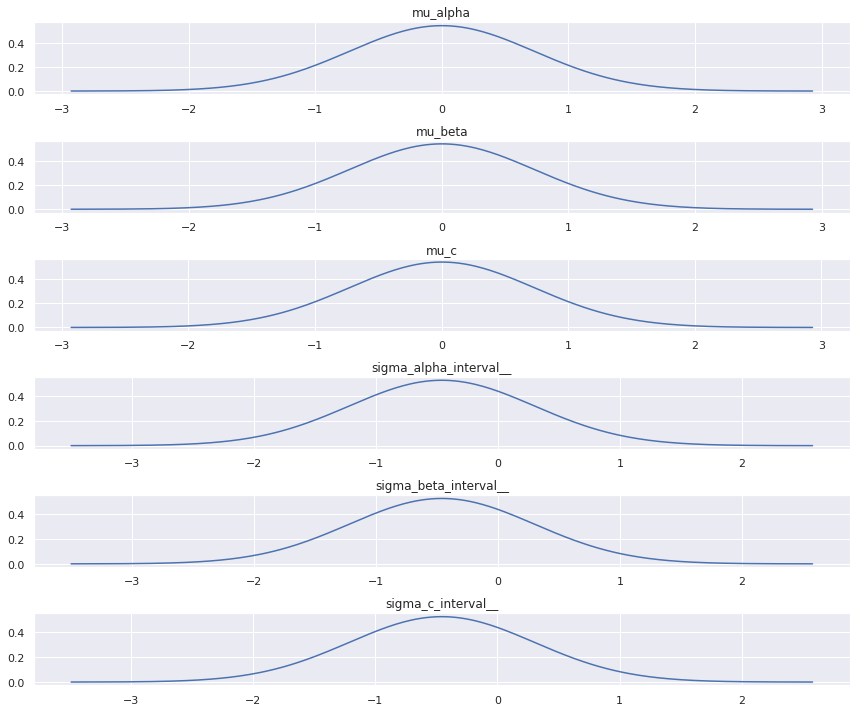

In [107]:
category_names = ['Men','Women','Electronics','Sports','Beauty','Kids','Home','Other']
model_param = ['alpha','beta','c']
var_param = ['mu_alpha', 'mu_beta', 'mu_c' , 'sigma_alpha_interval__',  'sigma_beta_interval__', 'sigma_c_interval__']

from scipy import stats
import seaborn as sns
varnames = means.keys()
fig, axs = plt.subplots(nrows=6, figsize=(12, 10))

for var, ax in zip(var_param, axs):

    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
fig.tight_layout()